In [2]:
!pip install opencv-python torch torchvision supervision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [3]:
import cv2
import PIL

def extract_frames(video_path, interval=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            # Convert BGR to RGB immediately
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
        frame_count += 1

    cap.release()
    return frames

In [4]:
from transformers import pipeline
import supervision as sv
import numpy as np

depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-large-hf")
segmenter = pipeline("image-segmentation", model="facebook/mask2former-swin-large-coco-panoptic")

from PIL import Image
import cv2

from transformers import Mask2FormerImageProcessor

# Initialize processor for proper mask decoding
processor = Mask2FormerImageProcessor()



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/82.2k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/866M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

Device set to use cpu


In [19]:
import numpy as np
import cv2
from PIL import Image
from transformers import pipeline

def process_frame_with_roi(frame,roi):
    """
    Processes a frame with a pre-defined ROI, calculating depth and creating a mask.

    Args:
        frame: The image frame (NumPy array).
        roi_coordinates: A list or tuple of (x1, y1, x2, y2) coordinates
                         representing the top-left and bottom-right corners of the ROI.

    Returns:
        A tuple containing the depth map and a list containing the ROI mask (as a "wagon_mask").
        Returns (None, None) if ROI coordinates are invalid.
    """


    height, width, _ = frame.shape

    # Validate ROI coordinates (same as before) (461, 3, 1846, 1937)
    x1, y1, x2, y2 = roi
    if not (0 <= x1 < width and 0 <= y1 < height and 0 <= x2 < width and 0 <= y2 < height and x1 < x2 and y1 < y2):
        print("Invalid ROI coordinates.")
        return None, None

    # 1. Depth Estimation (same as before)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    depth_result = depth_estimator(pil_image)
    depth_map = np.array(depth_result["depth"])

    # 2. Create ROI Mask (same as before)
    mask = np.zeros((height, width), dtype=np.uint8)
    mask[y1:y2, x1:x2] = 255

    # 3. Prepare the wagon_masks list (containing just the ROI mask)
    wagon_masks = [mask] # Put the mask in a list, just like the segmentation version
    return depth_map, wagon_masks , depth_result



In [6]:
def calibrate_depth(wagon_mask, depth_map, reference_length_pixels, reference_real_length):
    """
    Calculate depth scaling factor using known reference dimension
    (e.g., wagon width or height in real world)
    """
    # Get pixel coordinates of reference dimension
    y, x = np.where(wagon_mask)
    pixel_length = max(x.max() - x.min(), y.max() - y.min())
    print(f"Pixel length: {pixel_length}")
    # Calculate scale factor (meters per pixel)
    scale_factor = reference_real_length / pixel_length
    return scale_factor

In [7]:
def calculate_volume(depth_map, mask, scale_factor):
    masked_depth = depth_map * mask
    material_height = masked_depth.max() - masked_depth.min()

    # Calculate area in real-world units
    pixel_area = np.sum(mask)
    real_area = pixel_area * (scale_factor ** 2)

    volume = real_area * material_height * scale_factor
    return volume

In [8]:
from collections import defaultdict

def process_video(video_path,roi,track_id):

    frames = extract_frames(video_path)

    wagon_volumes = defaultdict(list)

    for frame in frames:
        depth_map, wagon_masks = process_frame_with_roi(frame,roi)

        for idx, mask in enumerate(wagon_masks):
            # Implement tracking ID (could use ByteTrack or simple centroid tracking)
             # Implement tracking logic

            # Get reference dimension (from known wagon specs)
            scale = calibrate_depth(mask, depth_map,
                                  reference_length_pixels=150,
                                  reference_real_length=2.5)  # 2.5m reference

            volume = calculate_volume(depth_map, mask, scale)
            wagon_volumes[track_id].append(volume)

    # Average volumes across frames
    final_volumes = {tid: np.mean(vals) for tid, vals in wagon_volumes.items()}
    return final_volumes

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
video_path = r"/content/drive/MyDrive/2 copy.mp4"
track_id = 1
roi = (461, 3, 1846, 1937)
# Execute the pipeline
final_volumes = process_video(video_path,roi,track_id)

# Print results
print("Wagon Volumes (cubic meters):")
for wagon_id, volume in final_volumes.items():
    print(f"Wagon {wagon_id}: {volume:.2f} m³")

In [20]:
depth_map, wagon_masks , depth_result = process_frame_with_roi(cv2.imread("/content/Screenshot 2025-02-01 at 11.09.23.png"),roi)

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]
[[ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]
 ...
 [60 60 61 ... 86 85 84]
 [58 58 60 ... 85 83 83]
 [57 58 60 ... 85 83 82]]
<class 'dict'>


In [25]:
print(depth_result)

{'predicted_depth': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.4381,  0.4149,  0.4092],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4413,  0.4185,  0.4130],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4562,  0.4353,  0.4302],
        ...,
        [54.4058, 54.7536, 56.2052,  ..., 80.1535, 78.7967, 78.4741],
        [52.7219, 53.1392, 54.8837,  ..., 79.0089, 77.3779, 76.9904],
        [52.3213, 52.7551, 54.5692,  ..., 78.7369, 77.0409, 76.6380]]), 'depth': <PIL.Image.Image image mode=L size=2548x1974 at 0x7F2080AC4D90>}


In [26]:
depth_result["depth"].show()


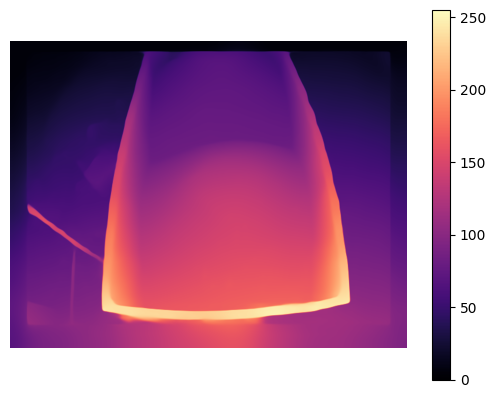

In [27]:
import numpy as np
import matplotlib.pyplot as plt

depth_image = np.array(depth_result["depth"])  # Convert PIL image to NumPy array

plt.imshow(depth_image, cmap="magma")  # Change cmap to 'gray' or 'viridis' if needed
plt.colorbar()
plt.axis("off")
plt.show()
